In [1]:
import os
import glob
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import copy


%matplotlib notebook

In [47]:
working_directory = r"D:\MEA_DATA_Aachen\ANALYZED\2021-05-17_cortex_div11_aCSF_ID046_nodrug_spont_1_analyzed_on_03082021"

output_directory = r"D:\MEA_DATA_Aachen\ANALYZED\figures_feldmeyermeeting\div11"

In [48]:
os.chdir(working_directory)

In [49]:
filename=working_directory.split('\\')[3]

In [50]:
#filebase=filename.split()

In [51]:
filelist = glob.glob('*.npy')

In [52]:
spike_dic_filename = glob.glob('*spikes*')[0]
info_dic = glob.glob('*info*')[0]

In [53]:
spikedic_MAD = np.load(spike_dic_filename, allow_pickle=True).item()
info_dic = np.load(info_dic, allow_pickle=True).item()

In [54]:
tick = info_dic['tick']
timelengthrecording_s = info_dic['timelengthrecording_s']
first_recording_timepoint = info_dic['first_recording_timepoint']
scale_factor_for_second = info_dic['scale_factor_for_second']


In [55]:
# cross this out if you want them in the original directory
os.chdir(output_directory)

In [56]:
 # create an array of the spikes in scale of seconds
active_channels = 0
spikedic_seconds = {}
for key in spikedic_MAD:
    relevant_factor = timelengthrecording_s*0.05
    if len(spikedic_MAD[key])>relevant_factor:
        sec_array = spikedic_MAD[key]*tick*scale_factor_for_second
        spikedic_seconds[key]=sec_array
        active_channels += 1
spikearray_seconds = np.asarray(list(spikedic_seconds.values()))  

In [57]:
timelengthrecording_s*0.05



6.005

In [58]:
active_channels

21

In [59]:
# get a 1-D array with every detected spike
scale_factor_for_milisecond = 1e-03
full_spike_list = []
full_spike_list_seconds = []
for key in spikedic_MAD:
    if len(spikedic_MAD[key])>relevant_factor:
        x = list(np.asarray(spikedic_MAD[key])*scale_factor_for_milisecond*tick)
        full_spike_list = full_spike_list + x

        xs = list(np.asarray(spikedic_MAD[key])*scale_factor_for_second*tick)
        full_spike_list_seconds = full_spike_list_seconds + xs
full_spikes = sorted(full_spike_list)
full_spikes_seconds = sorted(full_spike_list_seconds)

In [60]:
mean_fr_whole_recording = np.around((len(full_spikes_seconds) / timelengthrecording_s), 3)

In [61]:
 #define bins 
binsize = 0.005 #seconds
bins= np.arange(0, timelengthrecording_s+binsize, binsize)

# make a histogram 
full_spikes_binned = np.histogram(full_spikes_seconds, bins)[0]


#trial of population burst plot as inspired by Andrea Corna
bins = int(timelengthrecording_s / binsize)+1

firing_rate_histogram = np.histogram(full_spikes_seconds, bins=bins)
firing_rate = firing_rate_histogram[0]*200 #conversion to hertz

In [62]:
def gaussian_smoothing(y, window_size=10, sigma=2):

    filt = signal.gaussian(window_size, sigma)

    return signal.convolve(y, filt, mode='same')


In [63]:
N = int(1.5/binsize) # für eine Secunde, das Sliding window, also letztlich number of bins

# gaussian smmothing fo the firing rate and moving average
fr_gau = gaussian_smoothing(firing_rate)
ma_fr_gau = np.convolve(fr_gau, np.ones(N)/N, mode='same')
plt.plot(ma_fr_gau)

In [64]:
# we look for the mean of the MA as threshold
# we arrange this mean in an array for plotting
mean_ma_fr_gau = np.mean(ma_fr_gau)
network_burst_threshold = mean_ma_fr_gau
shape_for_threshold = np.shape(ma_fr_gau)
network_burst_threshold_array = np.full(shape_for_threshold, network_burst_threshold)
    

In [65]:
# now we identify the burts from the network and will extract an array with 
# tuples containing the burst start and end times
bursts= []
burst_start = []
burst_seconds_start = []
burst_end = []
burst_seconds_end = []
for index in range(0, len(ma_fr_gau[:-N])):
    if ma_fr_gau[index+N] > network_burst_threshold:
        if ma_fr_gau[index+N-1] <= network_burst_threshold:
            burst_start.append(index+N)
        if index == 0:
            burst_start.append(0)
            #burst_seconds_start.append((index+N)*0.005)
    else:
        if (ma_fr_gau[index+N-1] > network_burst_threshold) and (len(burst_start)>0):
            if index+N > len(ma_fr_gau):
                ending = len(ma_fr_gau)
            else: 
                ending = index + N

            burst_end.append(ending)
            #burst_seconds_end.append((ending)*0.005)
bursts = list(zip(burst_start, burst_end))
    

In [66]:
# get the bursts into seconds
for i in burst_start:
    burst_seconds_start.append(firing_rate_histogram[1][i])
for i in burst_end:
    burst_seconds_end.append(firing_rate_histogram[1][i])

bursts_seconds = list(zip(burst_seconds_start, burst_seconds_end))
# bursts sind jetzt im 5ms bin 
    

<IPython.core.display.Javascript object>


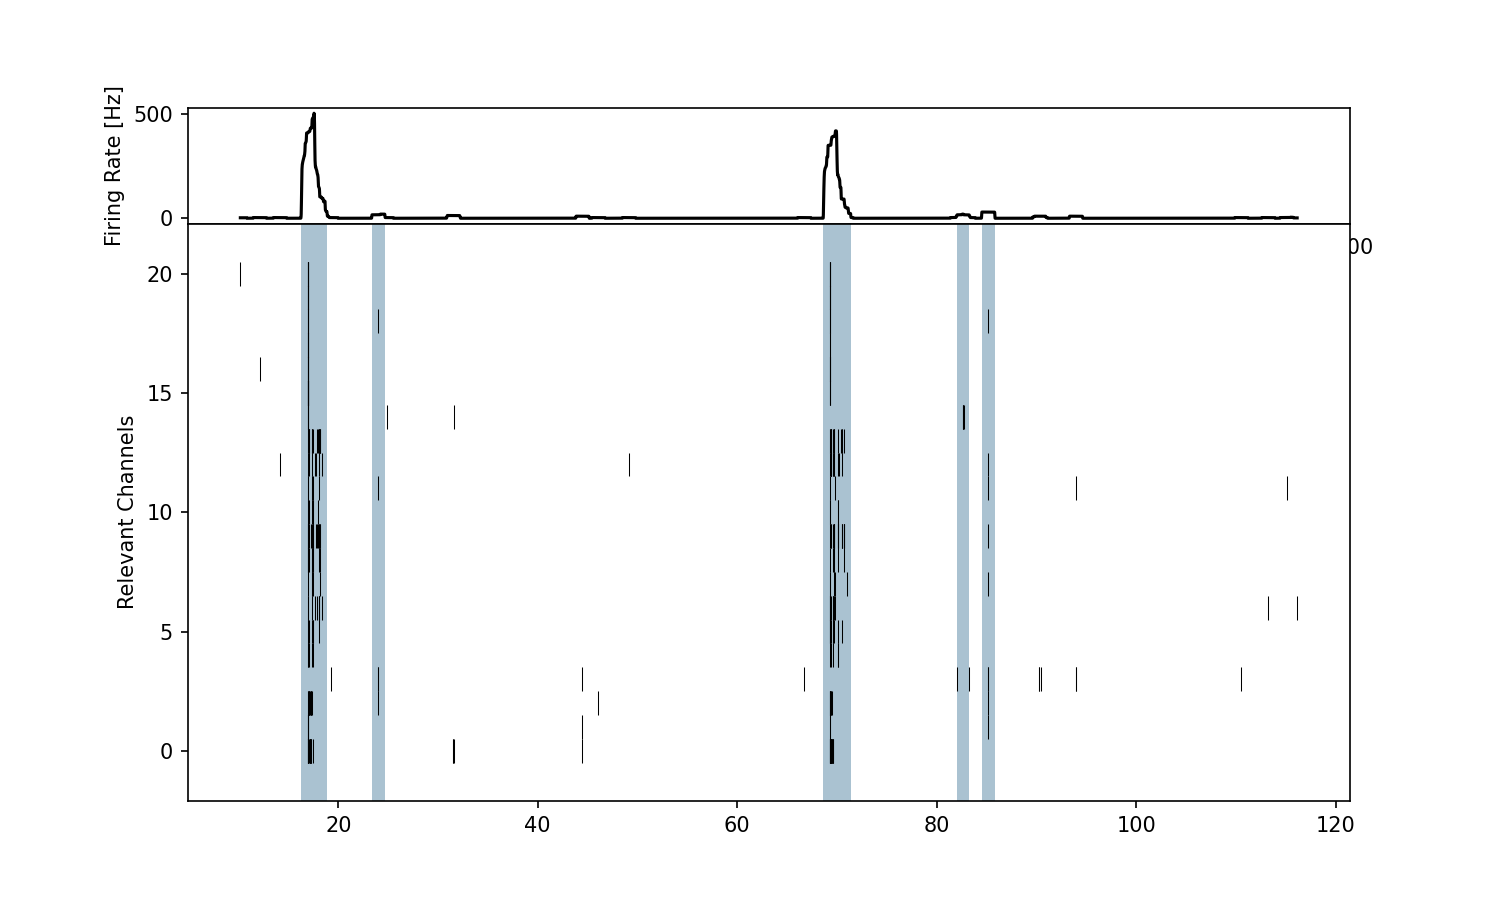

<ipython-input-67-ae1e3c645dbc>:6: MatplotlibDeprecationWarning: "color" keyword argument will be ignored
  axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,


In [67]:
fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,
                 linelengths = 1, colors = 'black')
axs[1].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[1].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)
#fig.savefig(filename+ '__raster_firingrate_plot.png', dpi=300)



<IPython.core.display.Javascript object>


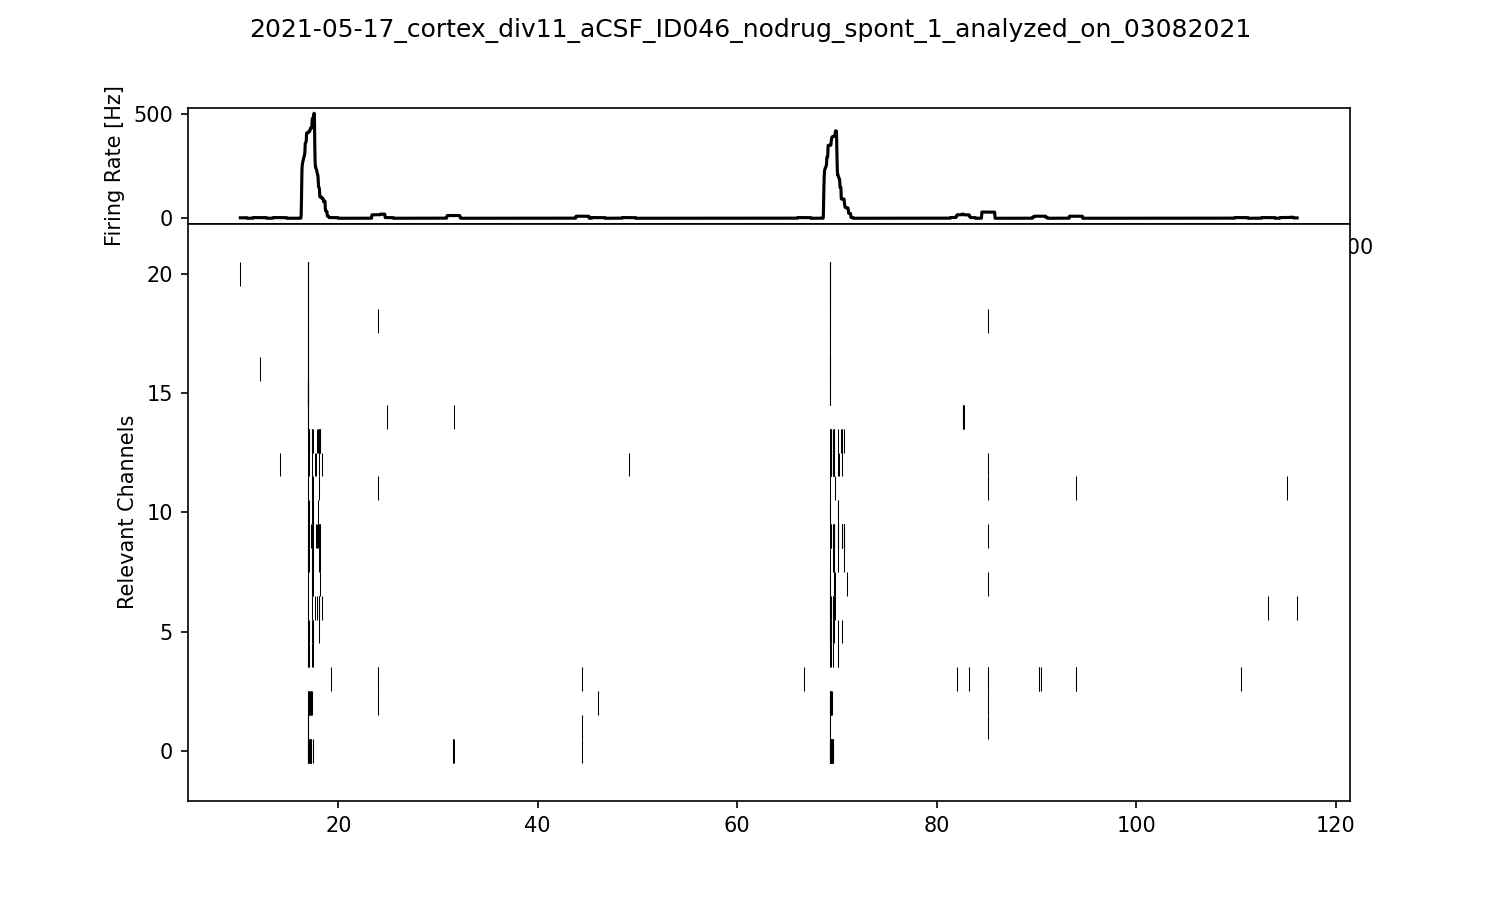

<ipython-input-68-c4b666c2c0f1>:6: MatplotlibDeprecationWarning: "color" keyword argument will be ignored
  axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,


Text(0.5, 0.98, '2021-05-17_cortex_div11_aCSF_ID046_nodrug_spont_1_analyzed_on_03082021')

In [68]:
fig = plt.figure(figsize = (10,6))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5,
                 linelengths = 1, colors = 'black')
axs[1].set_ylabel('Relevant Channels')
fig.suptitle(filename)

#for ax in axs:
#    for i in bursts_seconds:
#        axs[1].axvspan(i[0], i[1], facecolor = '#5B89A6', alpha = 0.3)
#fig.savefig(filename+ '__raster_firingrate_plot_solo.png', dpi=300)

In [69]:
# identify the longest burst and longest interburst-interval


In [70]:
#longest bursts:

longest_burst = 0
longest_burst_i = 0
for i in bursts_seconds:
    burstinterval = i[1]-i[0]
    if burstinterval > longest_burst:
        longest_burst = burstinterval
        longest_burst_i = i

In [71]:
# longest_interburst interval:

longest_ibi = 0
longest_ibi_times = (0, 0)

for i in range(1, len(bursts_seconds)-1):
    ibi = bursts_seconds[i+1][0] - bursts_seconds[i][1]
    if ibi > longest_ibi:
        longest_ibi = ibi
        longest_ibi_times = ((bursts_seconds[i][1]), (bursts_seconds[i+1][0])) 

In [72]:
longest_ibi_times

(24.67500275092627, 68.63503543899088)

<IPython.core.display.Javascript object>


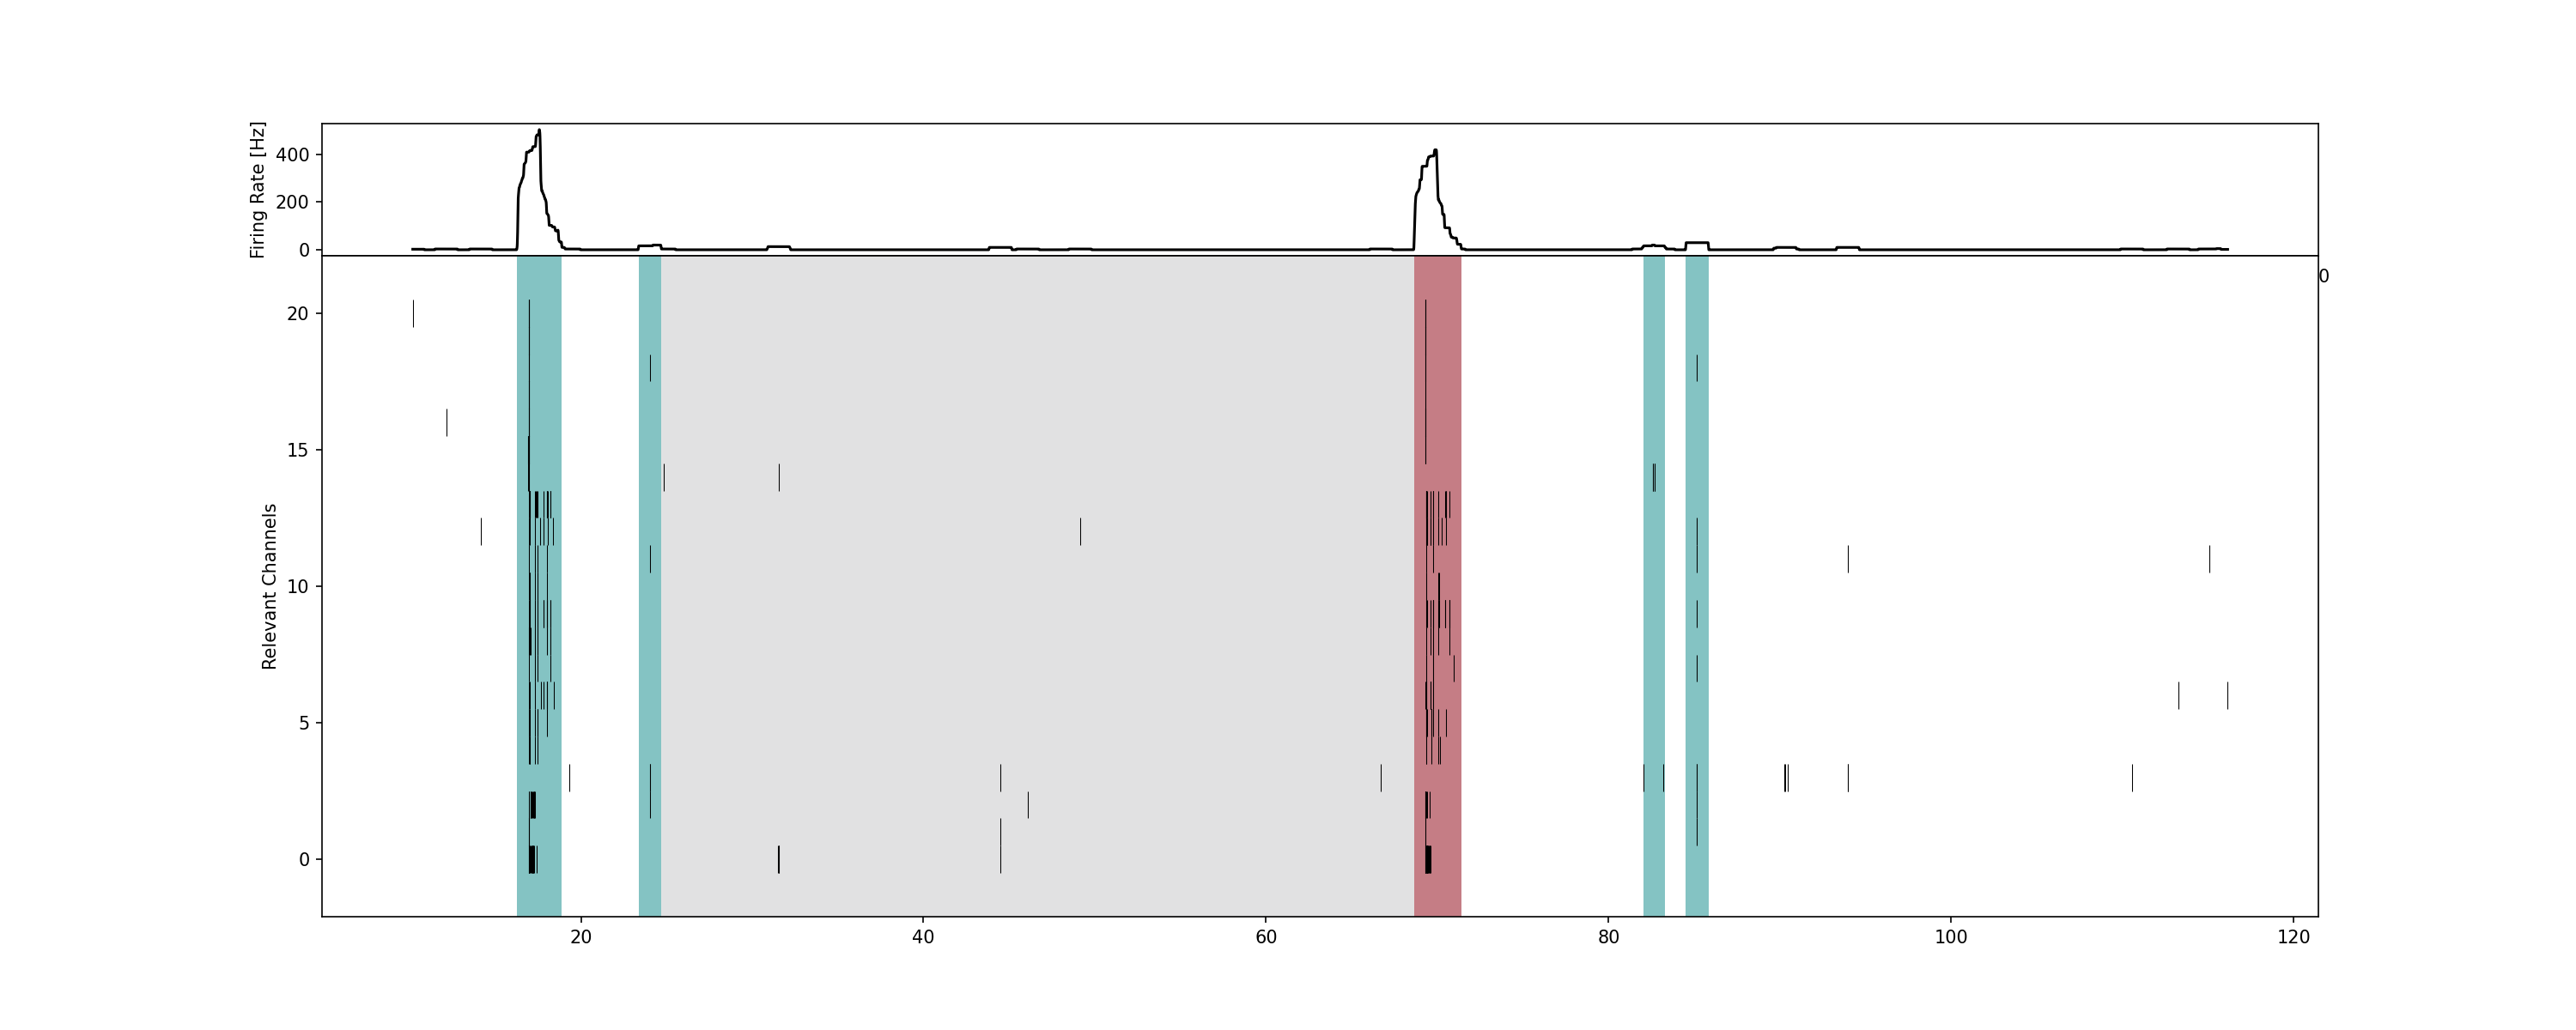

In [73]:
fig = plt.figure(figsize = (20,8))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5, linelengths = 1)
axs[1].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[1].axvspan(i[0], i[1], facecolor = '#118C8C', alpha = 0.3)
        axs[1].axvspan(longest_burst_i[0], longest_burst_i[1], facecolor = '#F2727D', alpha = 0.2, label = 'longest network burst')
        axs[1].axvspan(longest_ibi_times[0], longest_ibi_times[1], facecolor = '#D7D7D9', alpha = 0.1, ls =':')
        
#fig.savefig(filename+'raster_and_FR_plot.png', dpi=300)
        


In [74]:
# next, we want to isolate these two areas for a spade analysis

In [75]:
def subdivide_spiketrain(spiketrain, sub_start = 0, sub_stop = 10, tick=40, scale_factor_for_second=1e-06):
    '''
    Excpects: 
        a spiketrain with tick datapoints
        default ticks are 40
        default scale_factor_for_seconds = 1e-06
        provide the start and stop of the desired sub in seconds
    
    Does:
        converts the desired seconds into data ticks
        checks if the spikes of the given spiketrain is in the desired subs
        substracts the starting time -->
        
    Returns:
        a spiketrain dictionary that again starts from zero
    
    '''
    sub_start_tick = sub_start / (tick*scale_factor_for_second)
    sub_stop_tick = sub_stop / (tick*scale_factor_for_second)
    sub_spiketrain = {}
  
    for key in spiketrain: 
        list_per_key = []
        for i in spiketrain[key]:
            if (i>=sub_start_tick ) & (i<sub_stop_tick):
                list_per_key.append(int(i-sub_start_tick))
        sub_spiketrain[key]=list_per_key

    return sub_spiketrain

In [76]:
burst_seconds_start

[16.275614668831437,
 23.364804084759168,
 68.63503543899088,
 82.02817735981016,
 84.50299706257024]

In [77]:
burst_seconds_end

[18.88718911452479,
 24.67500275092627,
 71.38777607093792,
 83.26779293285043,
 85.83084150201907]

In [78]:
st_longest_burst = subdivide_spiketrain(spikedic_MAD, longest_burst_i[0], longest_burst_i[1])

In [79]:
st_longest_ibi = subdivide_spiketrain(spikedic_MAD, longest_ibi_times[0], longest_ibi_times[1])

In [80]:
# in the next step, we want to find the firing rates for every channel in hertz for these subdivisions

longest_burst_firingrate_dic = {}

for key in st_longest_burst:
    fr_channel = len(st_longest_burst[key])/longest_burst # i.e, number of spikes divided by duration -> results in number per second
    longest_burst_firingrate_dic[key] = fr_channel

In [81]:
# same is done for the longest interburst interval

longest_ibi_firingrate_dic = {}

for key in st_longest_ibi:
    fr_channel = len(st_longest_ibi[key])/longest_ibi # i.e, number of spikes divided by duration -> results in number per second
    longest_ibi_firingrate_dic[key] = fr_channel

In [82]:
# and lastly for the whole recording

whole_recording_firingrate_dic = {}

for key in spikedic_MAD:
    fr_channel = len(spikedic_MAD[key])/timelengthrecording_s # i.e, number of spikes divided by duration -> results in number per second
    whole_recording_firingrate_dic[key] = fr_channel

In [83]:
# next we plot this on a mea array:

mea_array=np.empty((16,16,))
mea_array[:]=np.nan
columnlist =['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']
df = pd.DataFrame(data=mea_array,columns=columnlist)
df.index+=1

df1 = pd.DataFrame(data=mea_array,columns=columnlist)
df1.index+=1

df2 = pd.DataFrame(data=mea_array,columns=columnlist)
df2.index+=1


In [84]:
# function to fill the dataframe with the 

def get_dict_values(df, dic):
    
    for i in df.columns:
        for j in range(0, 16):
            keystring = i+str(df.index[j])
            #print(keystring)
            if keystring in dic.keys():
                df.loc[df.index[j],i]=dic[keystring]
            
                
    
    return df

In [85]:
use_df_copy = df.copy()
use_df_copy1 = df1.copy()
use_df_copy2 = df2.copy()

In [86]:
#the dataframe for burst


df_fr_burst = get_dict_values(use_df_copy, longest_burst_firingrate_dic)

In [87]:
df_fr_burst

,A,B,C,D,E,F,G,H,J,K,L,M,N,O,P,R
1,NaN,0.0,0.0,0.000000,0.00000,0.000000,0.363274,1.816372,0.363274,0.726549,4.359292,0.363274,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.000000,0.00000,1.816372,1.453097,3.632743,2.179646,6.902212,5.449115,1.089823,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.363274,0.00000,0.363274,0.000000,3.632743,0.000000,1.453097,0.726549,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.363274,0.000000,0.000000,0.726549,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.000000,0.00000,0.363274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [88]:
# data frame for interburst interval
df_fr_ibi = get_dict_values(use_df_copy1, longest_ibi_firingrate_dic)

In [89]:
df_fr_burst

,A,B,C,D,E,F,G,H,J,K,L,M,N,O,P,R
1,NaN,0.0,0.0,0.000000,0.00000,0.000000,0.363274,1.816372,0.363274,0.726549,4.359292,0.363274,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.000000,0.00000,1.816372,1.453097,3.632743,2.179646,6.902212,5.449115,1.089823,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.363274,0.00000,0.363274,0.000000,3.632743,0.000000,1.453097,0.726549,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.363274,0.000000,0.000000,0.726549,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.000000,0.00000,0.363274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


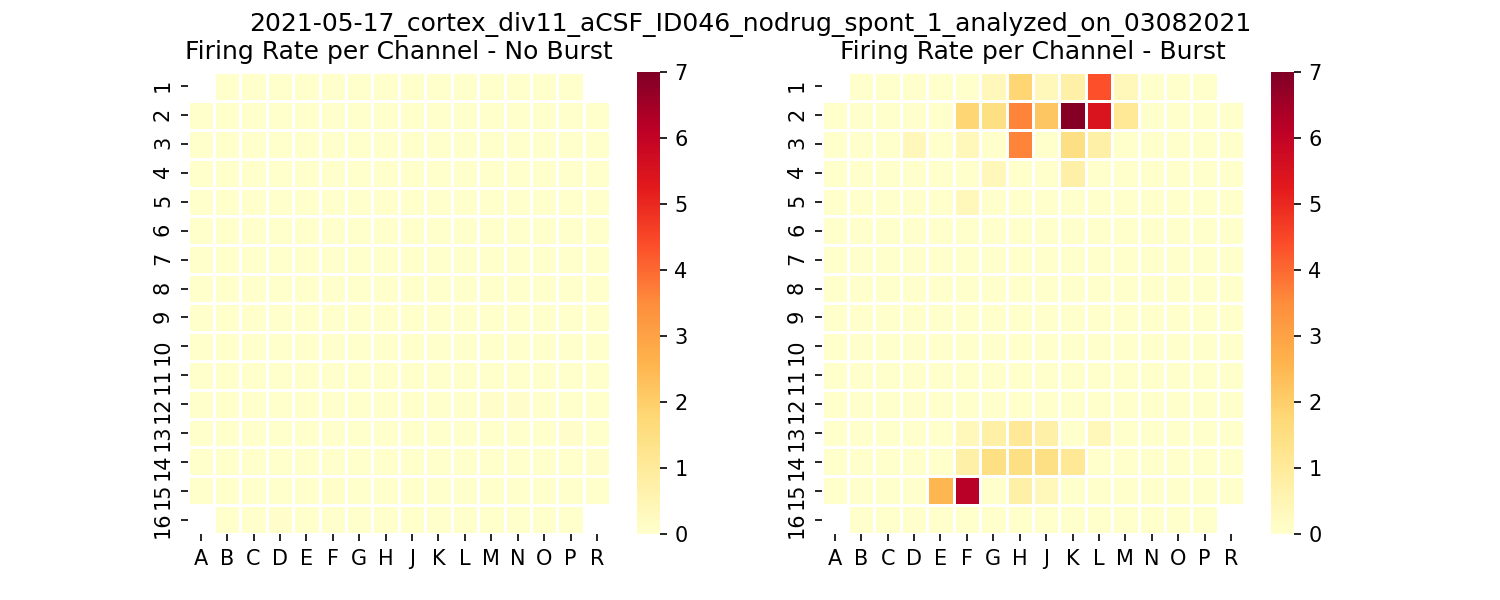

Text(0.5, 1.0, 'Firing Rate per Channel - Burst')

In [90]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

f.suptitle(filename)
sns.heatmap(df_fr_ibi, annot=False, linewidths=.5, ax=ax1, cmap="YlOrRd", vmax=7)
ax1.set_title('Firing Rate per Channel - No Burst')


sns.heatmap(df_fr_burst, annot=False, linewidths=.5, ax=ax2, cmap="YlOrRd", vmax=7)
ax2.set_title('Firing Rate per Channel - Burst')

#f.savefig(filename+'_MEA_Heatmap.png', dpi = 300)



In [91]:
df_fr_whole = get_dict_values(use_df_copy2, whole_recording_firingrate_dic)

In [92]:
df_fr_whole

,A,B,C,D,E,F,G,H,J,K,L,M,N,O,P,R
1,NaN,0.008326,0.008326,0.008326,0.000000,0.000000,0.041632,0.091590,0.024979,0.041632,0.183181,0.024979,0.000000,0.000000,0.000000,NaN
2,0.008326,0.000000,0.008326,0.000000,0.000000,0.083264,0.041632,0.174854,0.141549,0.299750,0.266445,0.049958,0.000000,0.024979,0.000000,0.008326
3,0.008326,0.008326,0.016653,0.008326,0.000000,0.016653,0.000000,0.141549,0.033306,0.091590,0.024979,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.008326,0.016653,0.008326,0.008326,0.016653,0.008326,0.016653,0.008326,0.000000,0.099917,0.008326,0.000000,0.000000,0.000000,0.000000,0.016653
5,0.008326,0.000000,0.000000,0.000000,0.000000,0.016653,0.000000,0.000000,0.000000,0.000000,0.008326,0.008326,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.008326,0.008326,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008326,0.000000,0.000000,0.024979
7,0.008326,0.000000,0.000000,0.008326,0.008326,0.000000,0.000000,0.008326,0.000000,0.008326,0.000000,0.000000,0.008326,0.000000,0.000000,0.008326
8,0.000000,0.000000,0.000000,0.000000,0.016653,0.008326,0.000000,0.000000,0.000000,0.000000,0.008326,0.008326,0.008326,0.000000,0.000000,0.008326
9,0.000000,0.041632,0.016653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008326,0.000000,0.008326
10,0.008326,0.000000,0.008326,0.000000,0.008326,0.008326,0.000000,0.000000,0.000000,0.000000,0.016653,0.000000,0.000000,0.000000,0.000000,0.000000


In [93]:
'''
sum_mean_frs = 0
number_of_fr = 0
for key in whole_recording_firingrate_dic:
    if whole_recording_firingrate_dic[key] > 0:
        sum_mean_frs += whole_recording_firingrate_dic[key]
        number_of_fr += 1

mean_fr_whole_recording = np.around((sum_mean_frs/number_of_fr), 4)
'''

'\nsum_mean_frs = 0\nnumber_of_fr = 0\nfor key in whole_recording_firingrate_dic:\n    if whole_recording_firingrate_dic[key] > 0:\n        sum_mean_frs += whole_recording_firingrate_dic[key]\n        number_of_fr += 1\n\nmean_fr_whole_recording = np.around((sum_mean_frs/number_of_fr), 4)\n'

In [94]:
mean_fr_whole_recording

2.781

<IPython.core.display.Javascript object>


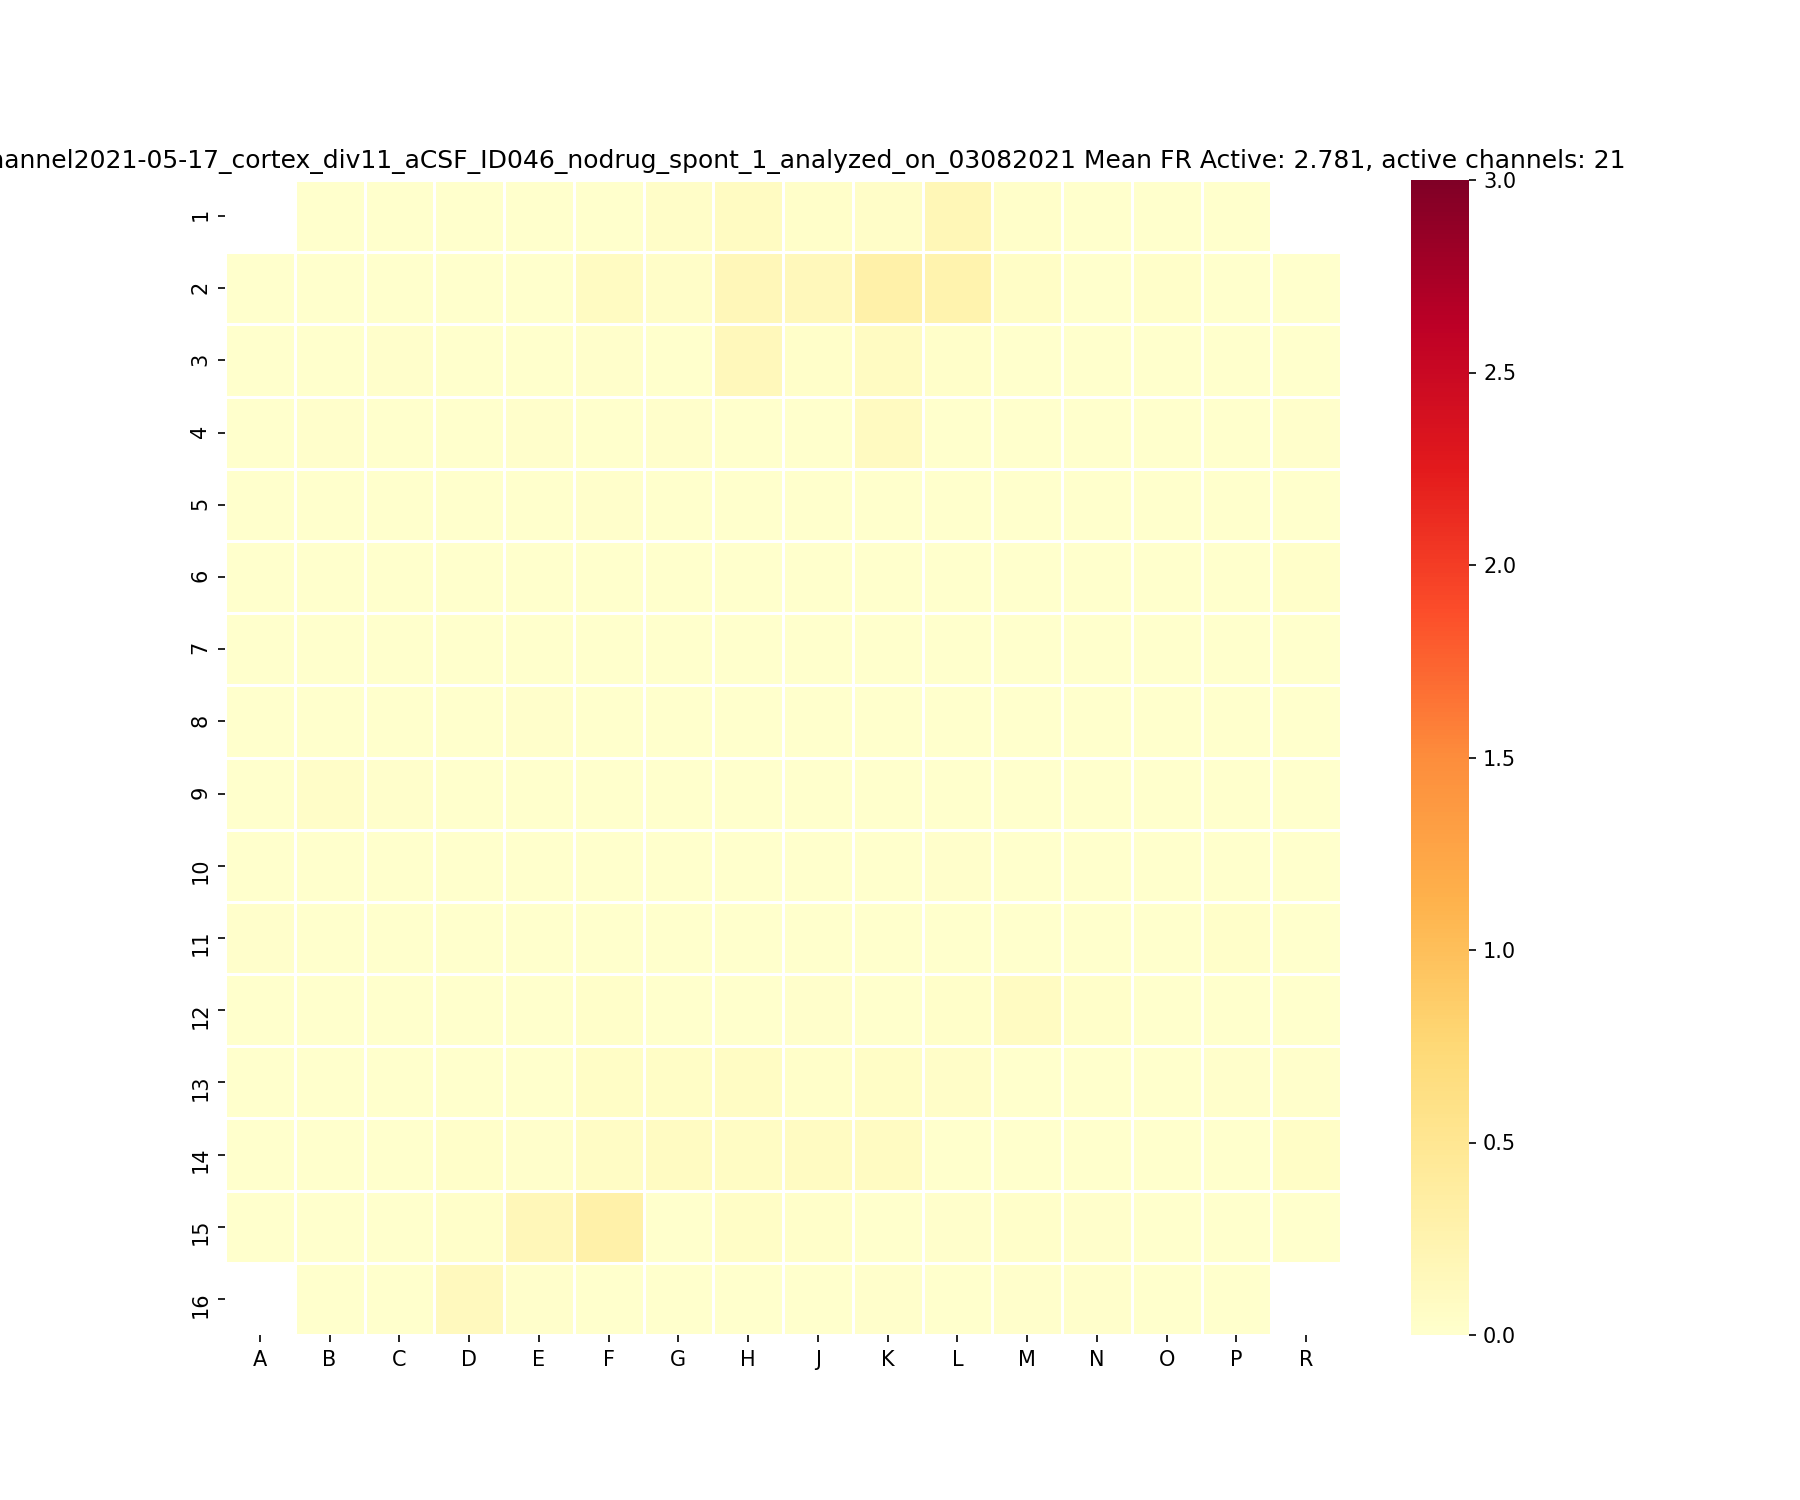

In [95]:
f, ax = plt.subplots(1, 1, figsize = (12,10))

sns.heatmap(df_fr_whole, annot=False, linewidths=.5, ax=ax, cmap="YlOrRd", vmax=3)
ax.set_title('Fr Channel' + filename + ' Mean FR Active: {}, active channels: {}'.format(mean_fr_whole_recording, active_channels))

f.savefig(filename+'whole_MEA_Heatmap.png', dpi = 300)

In [1402]:
np.save(filename+'sub_recording_BURST.npy', st_longest_burst)
np.save(filename+'sub_recording_NON-BURST.npy', st_longest_ibi)

In [1403]:
filename

'2021-05-14_cortex_div8_hCSF_ID042_30µMCNQX_spont_1_analyzed_on_05082021'

In [ ]:
#overviewframe_ac = pd.DataFrame(columns=['aCSF', 'aCSF + 30µM Nor', 'rewash aCSF', 'hCSF', 'hCSF + CNQX'], index=['DIV8', 'DIV11'])

In [ ]:
#overviewframe_fr = pd.DataFrame(columns=['aCSF', 'aCSF + 30µM Nor', 'rewash aCSF', 'hCSF', 'hCSF + CNQX'], index=['DIV8', 'DIV11'])

In [1404]:
#overviewframe_fr.iloc[0, 4]=mean_fr_whole_recording

In [1405]:
#overviewframe_ac.iloc[0, 4]=active_channels

In [1406]:
#overviewframe_fr

,aCSF,aCSF + 30µM Nor,rewash aCSF,hCSF,hCSF + CNQX
DIV8,0.497,9.038,5.246,14.517,2.339
DIV11,2.781,25.947,12.122,4.741,NaN


In [1407]:
overviewframe_ac

,aCSF,aCSF + 30µM Nor,rewash aCSF,hCSF,hCSF + CNQX
DIV8,7,29,20,31,9
DIV11,21,140,49,16,NaN


In [67]:
longest_burst_i

(61.8012997641196, 64.46957779069767)

# Subdivision of a Burst of Interest

In the next part we take a Network Burst and plot it on a small scale to see how the spikes develop. 

Further, we will divide it in 200ms parts to see how the spikes will develop temporarily over the MEA Grid.

<IPython.core.display.Javascript object>


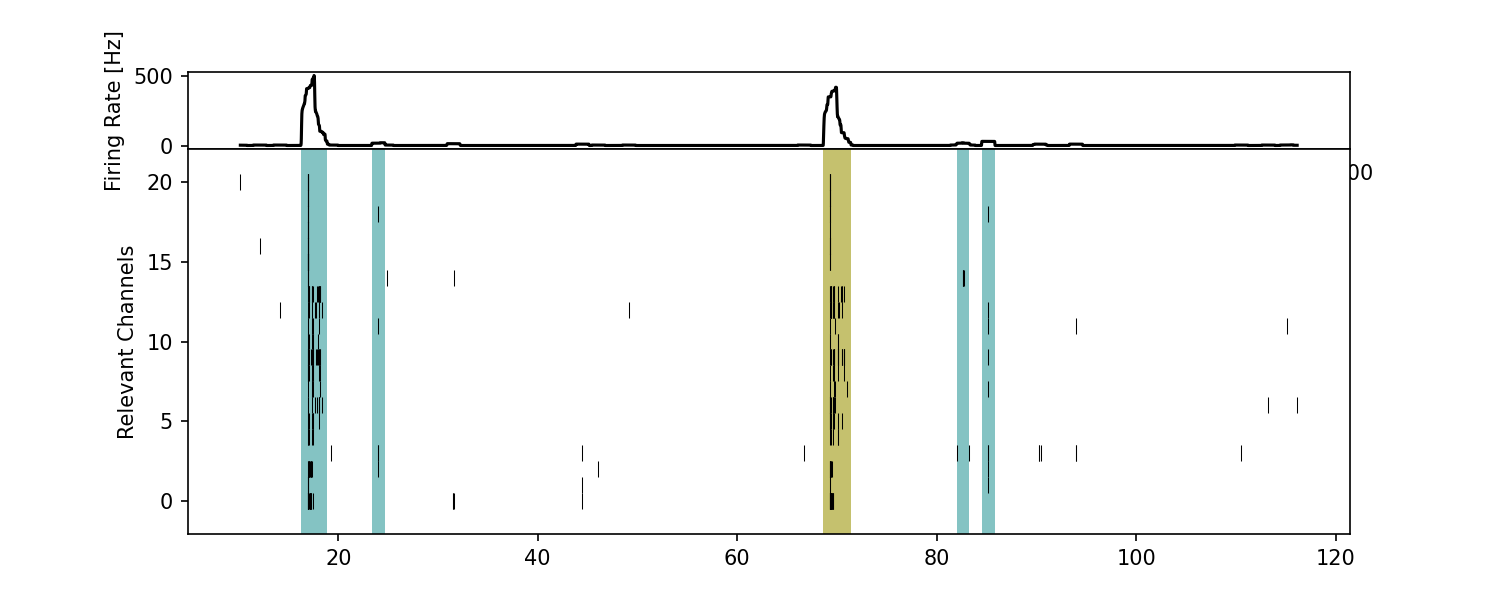

In [97]:
# we plot the beginning figure -> burst of interest is in yellow

# we choose the burst we want to plot and get start and end time in seconds
burst_of_interest = 2
b_of_interest_start = burst_seconds_start[burst_of_interest]
b_of_interest_end = burst_seconds_end[burst_of_interest]



fig = plt.figure(figsize = (10,4))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5, linelengths = 1)
axs[1].set_ylabel('Relevant Channels')

for ax in axs:
    for i in bursts_seconds:
        axs[1].axvspan(i[0], i[1], facecolor = '#118C8C', alpha = 0.3)
        
        axs[1].axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )
        
fig.savefig(filename+'raster_and_FR_plot_09082021.png', dpi=300, bbox_inches = 'tight')

In [98]:
# in the spikearray_seconds we have every spike used in the whole recording block
# we will now filter them to be in the time region of interest and create burst_of_interest_array

boi_array = []

for i in spikearray_seconds:
    channel_array_list = []
    for j in i:
        if (j >= b_of_interest_start) and (j <= b_of_interest_end):
            channel_array_list.append(j)
    channel_array = np.asarray(channel_array_list)
    boi_array.append(channel_array)

boi_array = np.asarray(boi_array)

<IPython.core.display.Javascript object>


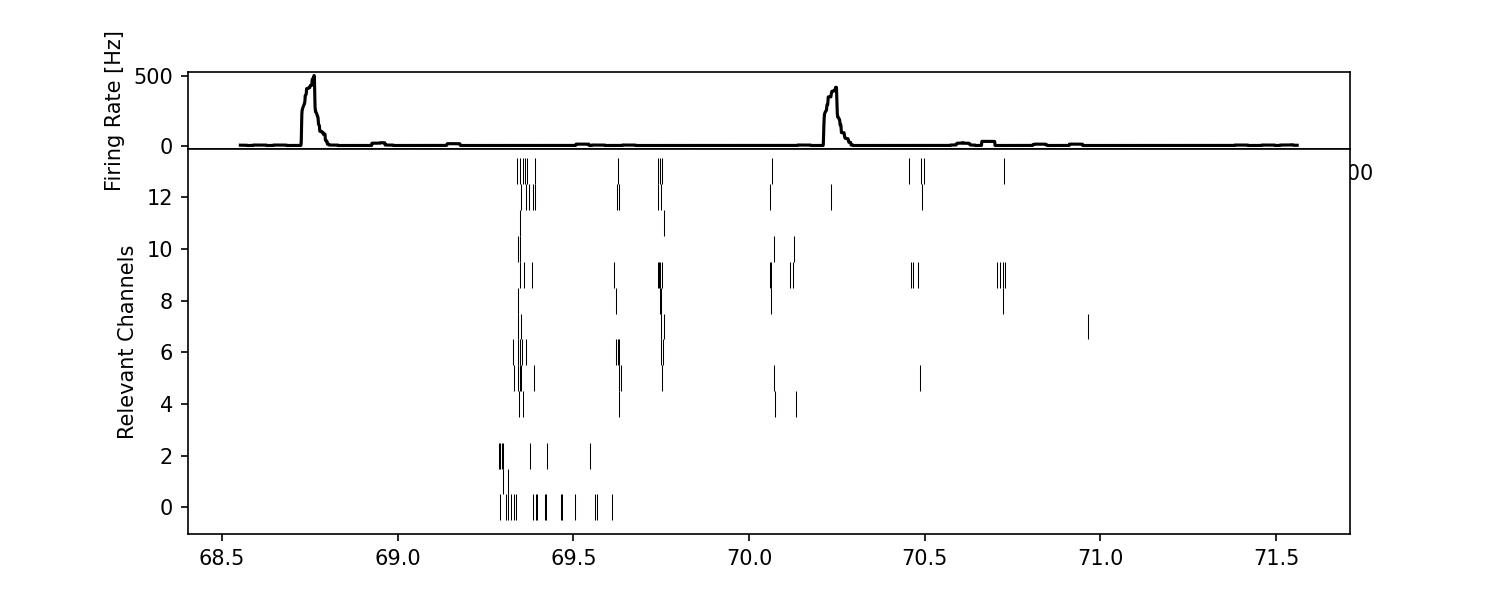

Text(0, 0.5, 'Relevant Channels')

In [99]:
# we can plot this subpart of the array

fig = plt.figure(figsize = (10,4))
gs = fig.add_gridspec(2, hspace = 0, height_ratios=[1,5])
axs = gs.subplots(sharex=False, sharey=False)
axs[0].plot(ma_fr_gau, color= 'black')
axs[0].set_ylabel('Firing Rate [Hz]')
axs[1].eventplot(spikearray_seconds, color = 'black', linewidths = 0.5, linelengths = 1)
axs[1].set_ylabel('Relevant Channels')


<IPython.core.display.Javascript object>


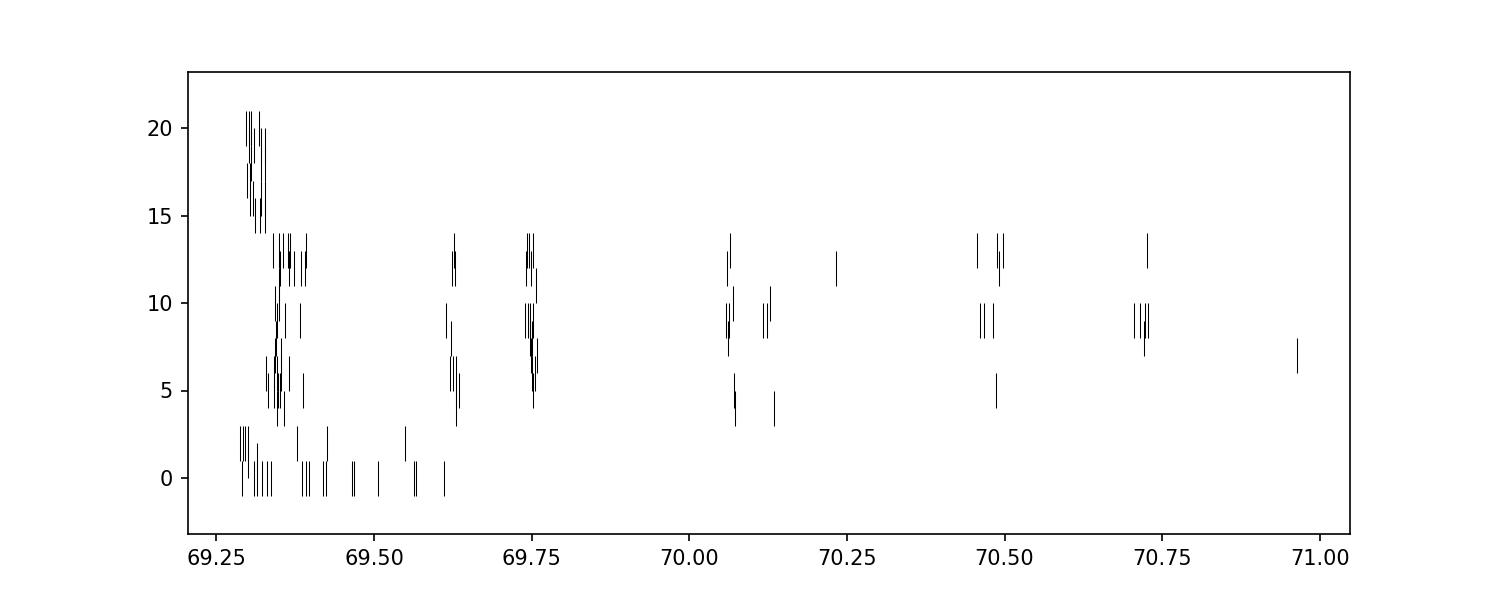

In [100]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)

In [108]:
# we use the subdivide function to get the st of the burst of interest

st_burst_of_interest = subdivide_spiketrain(spikedic_MAD, b_of_interest_start, b_of_interest_end)

In [133]:
# we now want to make heatmaps to picture the activity to observe the spatial propagation

# define how much time of the st you want to observe
heatmap_window = 0.2 # in seconds

#observed_time = b_of_interest_end-b_of_interest_start

#heatmap_window = observed_time/10 # in seconds


# make start and endpoints for each of these time-windows:

time_windows = []

# start of the subdivision = rounded start of the burst of interest
i = np.round(b_of_interest_start, 4)

# for every iteration, add the desired heatmap window
while i < b_of_interest_end:
    start = i
    stop = np.round(i+heatmap_window, 4)
    i = i + heatmap_window 
    if stop > b_of_interest_end:
        stop = b_of_interest_end
    time_windows.append((start, stop))
    
time_windows = time_windows[:10]


In [134]:
b_of_interest_start

68.63503543899088

In [135]:
time_windows

[(68.635, 68.835),
 (68.83500000000001, 69.035),
 (69.03500000000001, 69.235),
 (69.23500000000001, 69.435),
 (69.43500000000002, 69.635),
 (69.63500000000002, 69.835),
 (69.83500000000002, 70.035),
 (70.03500000000003, 70.235),
 (70.23500000000003, 70.435),
 (70.43500000000003, 70.635)]

<IPython.core.display.Javascript object>


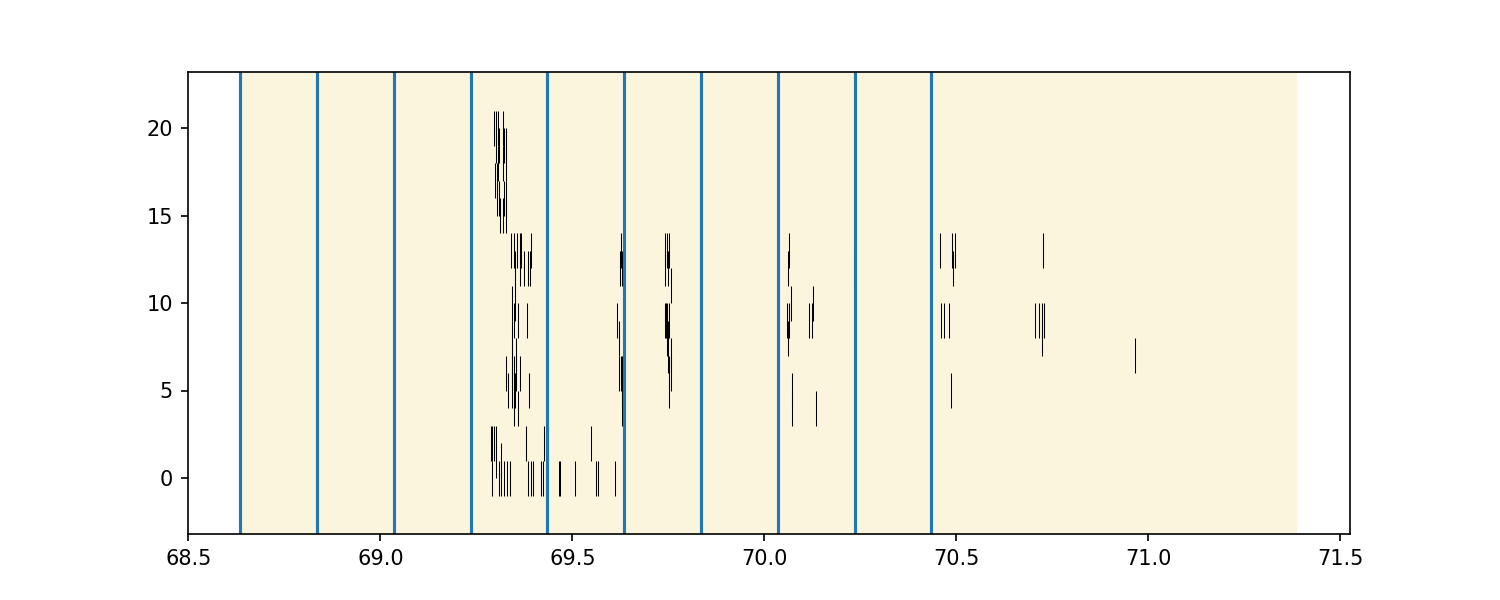

In [136]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)
ax = plt.axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )

# plot the lines for the subdivisions
for i in time_windows:
    ax = plt.axvline(i[0])
    
    
fig.savefig(filename + '_interesting_burst_09082021.png', dpi=300, bbox_inches = 'tight')


In [137]:
# we can now
len(time_windows)

10

In [138]:
# we will now create a dictionary with key = starts of the subdivision
# and values = dictionary  of the corresponding spiketrains

subdivided_boi_st = {}
subdivided_boi_fr = {}

for i in time_windows:
    #empty dic for firing rates
    fr_subs = {}
    
    # get the spiketrains for the time subpart
    st = subdivide_spiketrain(spikedic_MAD, i[0], i[1])
    
    # assign the subdivided dictionary to the subdivision dictionary
    subdivided_boi_st[i[0]] = st
    
    # for firing rate, we calculate the fr for each channel
    for key in st:
        fr = len(st[key]) / (i[1]-i[0])
        
        #assign the firing rate to that key
        fr_subs[key] = fr
     
    # the value for the subdivision key is that used subdic, which is emptied in the next loop
    subdivided_boi_fr[i[0]] = fr_subs
        
    
    

In [139]:
# how many subplots we want to create
number_of_heatmaps = len(time_windows)

number_columns = int(number_of_heatmaps / 2)




In [140]:
# for plotting with sns heatmap we need a df first 

# this is done as empty df:

mea_array=np.empty((16,16,))
mea_array[:]=np.nan
columnlist =['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']
df = pd.DataFrame(data=mea_array,columns=columnlist)
df.index+=1


In [141]:
df

,A,B,C,D,E,F,G,H,J,K,L,M,N,O,P,R
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


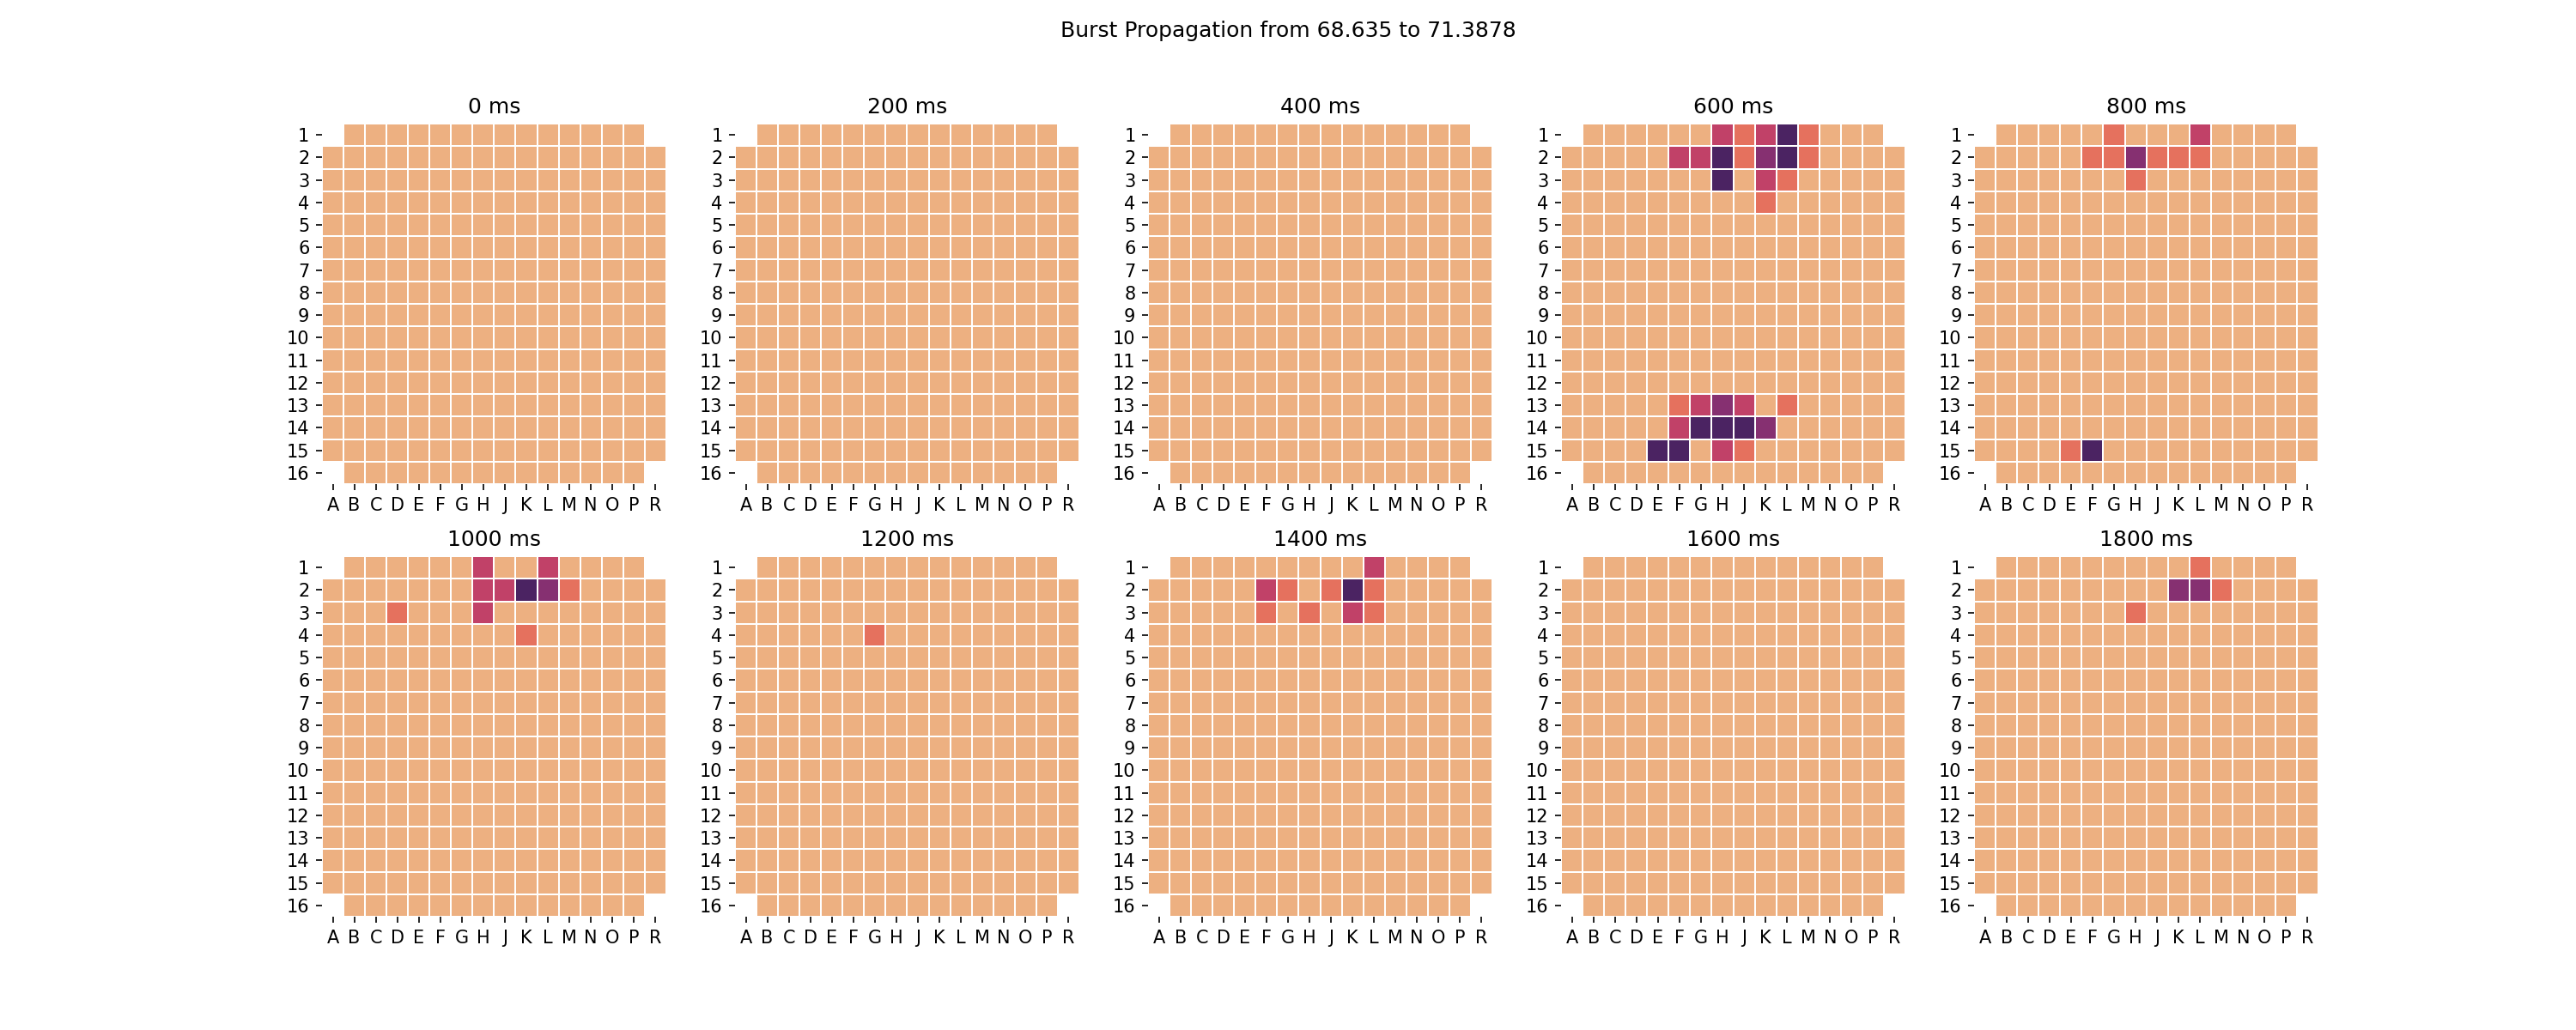

In [143]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

fig.savefig(filename+'_divided_burst_spatial_09082021.png', dpi=300, bbox_inches = 'tight')



## we can try what happens if we zoom in further

In [144]:
b_of_interest_start = 69.2
b_of_interest_end = 69.6

<IPython.core.display.Javascript object>


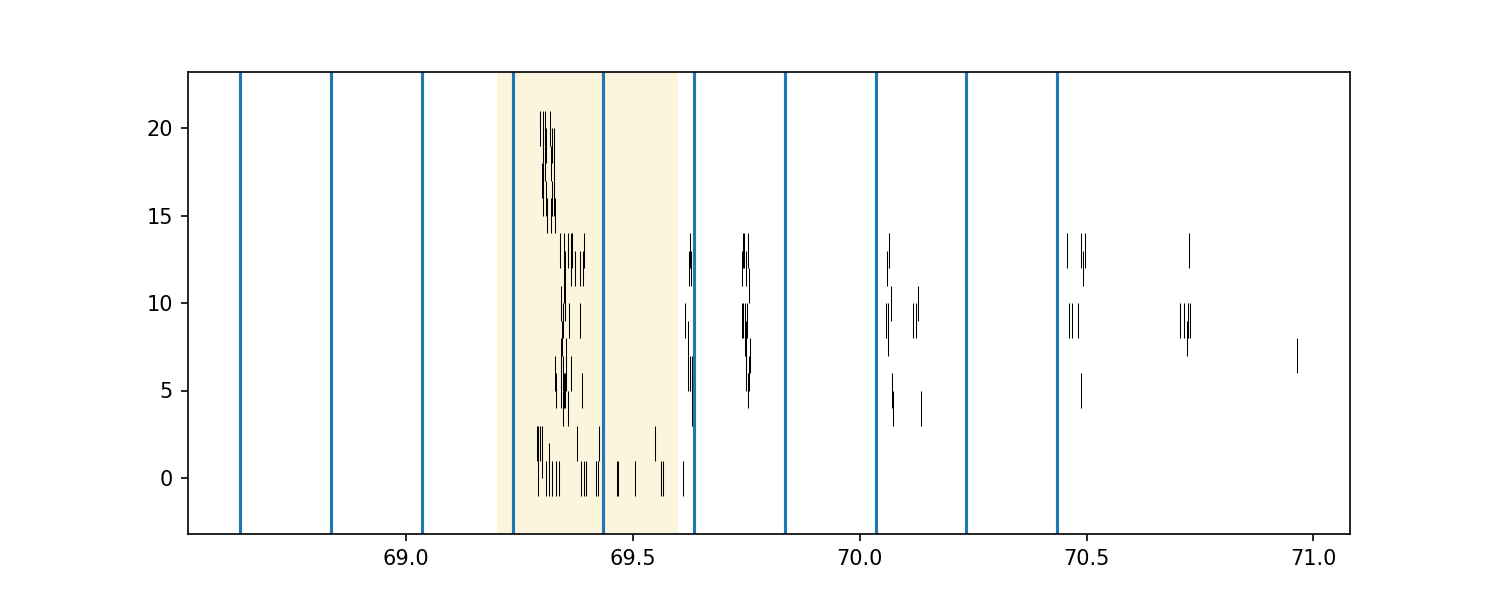

In [146]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)
ax = plt.axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )

# plot the lines for the subdivisions
for i in time_windows:
    ax = plt.axvline(i[0])
    
    
fig.savefig(filename + '_interesting_burst_09082021_zooming.png', dpi=300, bbox_inches = 'tight')

In [155]:
# we now want to make heatmaps to picture the activity to observe the spatial propagation

# let us make the heatmap window generic, so the burst is always subdivied into 10 subplots
observed_time = b_of_interest_end-b_of_interest_start

heatmap_window = observed_time/10 # in seconds

# make start and endpoints for each of these time-windows:

time_windows = []

# start of the subdivision = rounded start of the burst of interest
i = np.round(b_of_interest_start, 4)

# for every iteration, add the desired heatmap window
while i < b_of_interest_end:
    start = i
    stop = np.round(i+heatmap_window, 4)
    i = i + heatmap_window 
    if stop > b_of_interest_end:
        stop = b_of_interest_end
    time_windows.append((start, stop))

time_windows = time_windows[:10]

In [156]:
len(time_windows)

10

In [157]:
# we again obtain the array of that burst
# in the spikearray_seconds we have every spike used in the whole recording block
# we will now filter them to be in the time region of interest and create burst_of_interest_array

boi_array = []

for i in spikearray_seconds:
    channel_array_list = []
    for j in i:
        if (j >= b_of_interest_start) and (j <= b_of_interest_end):
            channel_array_list.append(j)
    channel_array = np.asarray(channel_array_list)
    boi_array.append(channel_array)

boi_array = np.asarray(boi_array)

In [158]:
b_of_interest_end

69.6

<IPython.core.display.Javascript object>


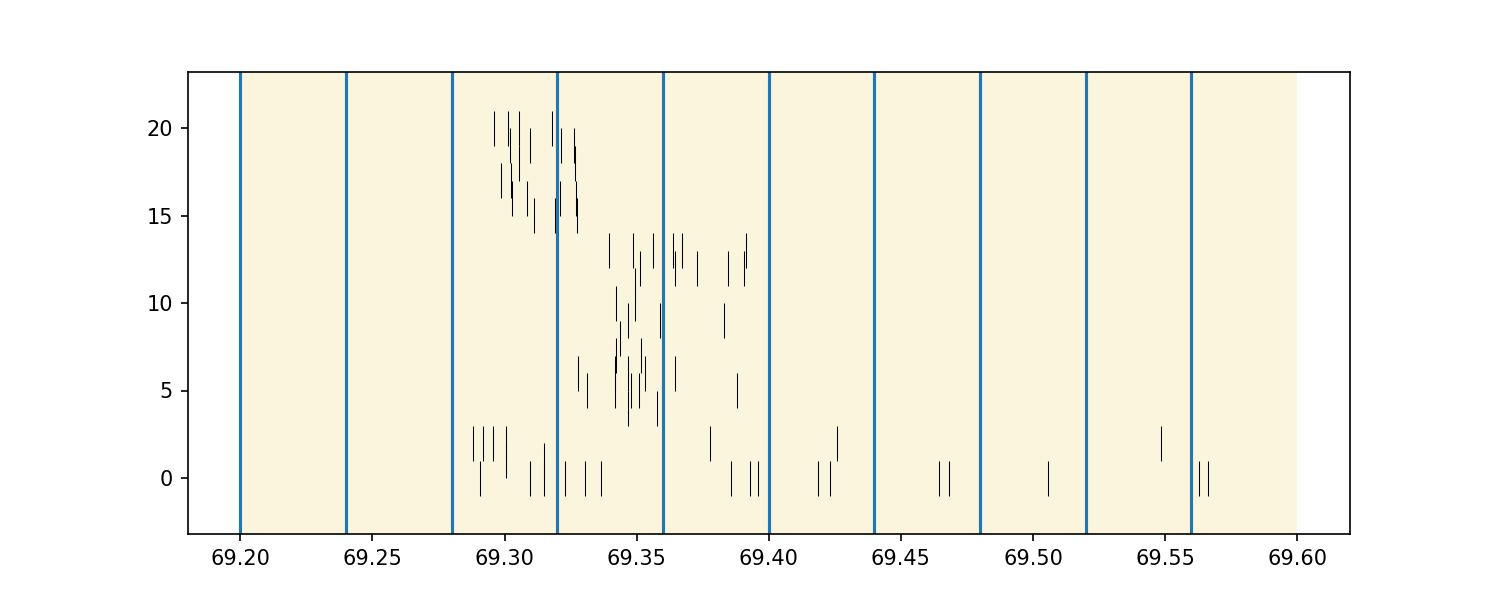

In [159]:
fig, ax = plt.subplots(1, 1, figsize = (10,4))

ax = plt.eventplot(boi_array, color = 'black', linewidths = 0.5, linelengths= 2)
ax = plt.axvspan(b_of_interest_start, 
                       b_of_interest_end, facecolor = '#F2CD5E', alpha = 0.2, 
                       label = 'longest network burst'
                      )

# plot the lines for the subdivisions
for i in time_windows:
    ax = plt.axvline(i[0])
    
    
fig.savefig(filename + '_interesting_burst_zoomed_09082021.png', dpi=300, bbox_inches = 'tight')

In [160]:
# we will now create a dictionary with key = starts of the subdivision
# and values = dictionary  of the corresponding spiketrains

subdivided_boi_st = {}
subdivided_boi_fr = {}

for i in time_windows:
    #empty dic for firing rates
    fr_subs = {}
    
    # get the spiketrains for the time subpart
    st = subdivide_spiketrain(spikedic_MAD, i[0], i[1])
    
    # assign the subdivided dictionary to the subdivision dictionary
    subdivided_boi_st[i[0]] = st
    
    # for firing rate, we calculate the fr for each channel
    for key in st:
        fr = len(st[key]) / (i[1]-i[0])
        
        #assign the firing rate to that key
        fr_subs[key] = fr
     
    # the value for the subdivision key is that used subdic, which is emptied in the next loop
    subdivided_boi_fr[i[0]] = fr_subs
        

<IPython.core.display.Javascript object>


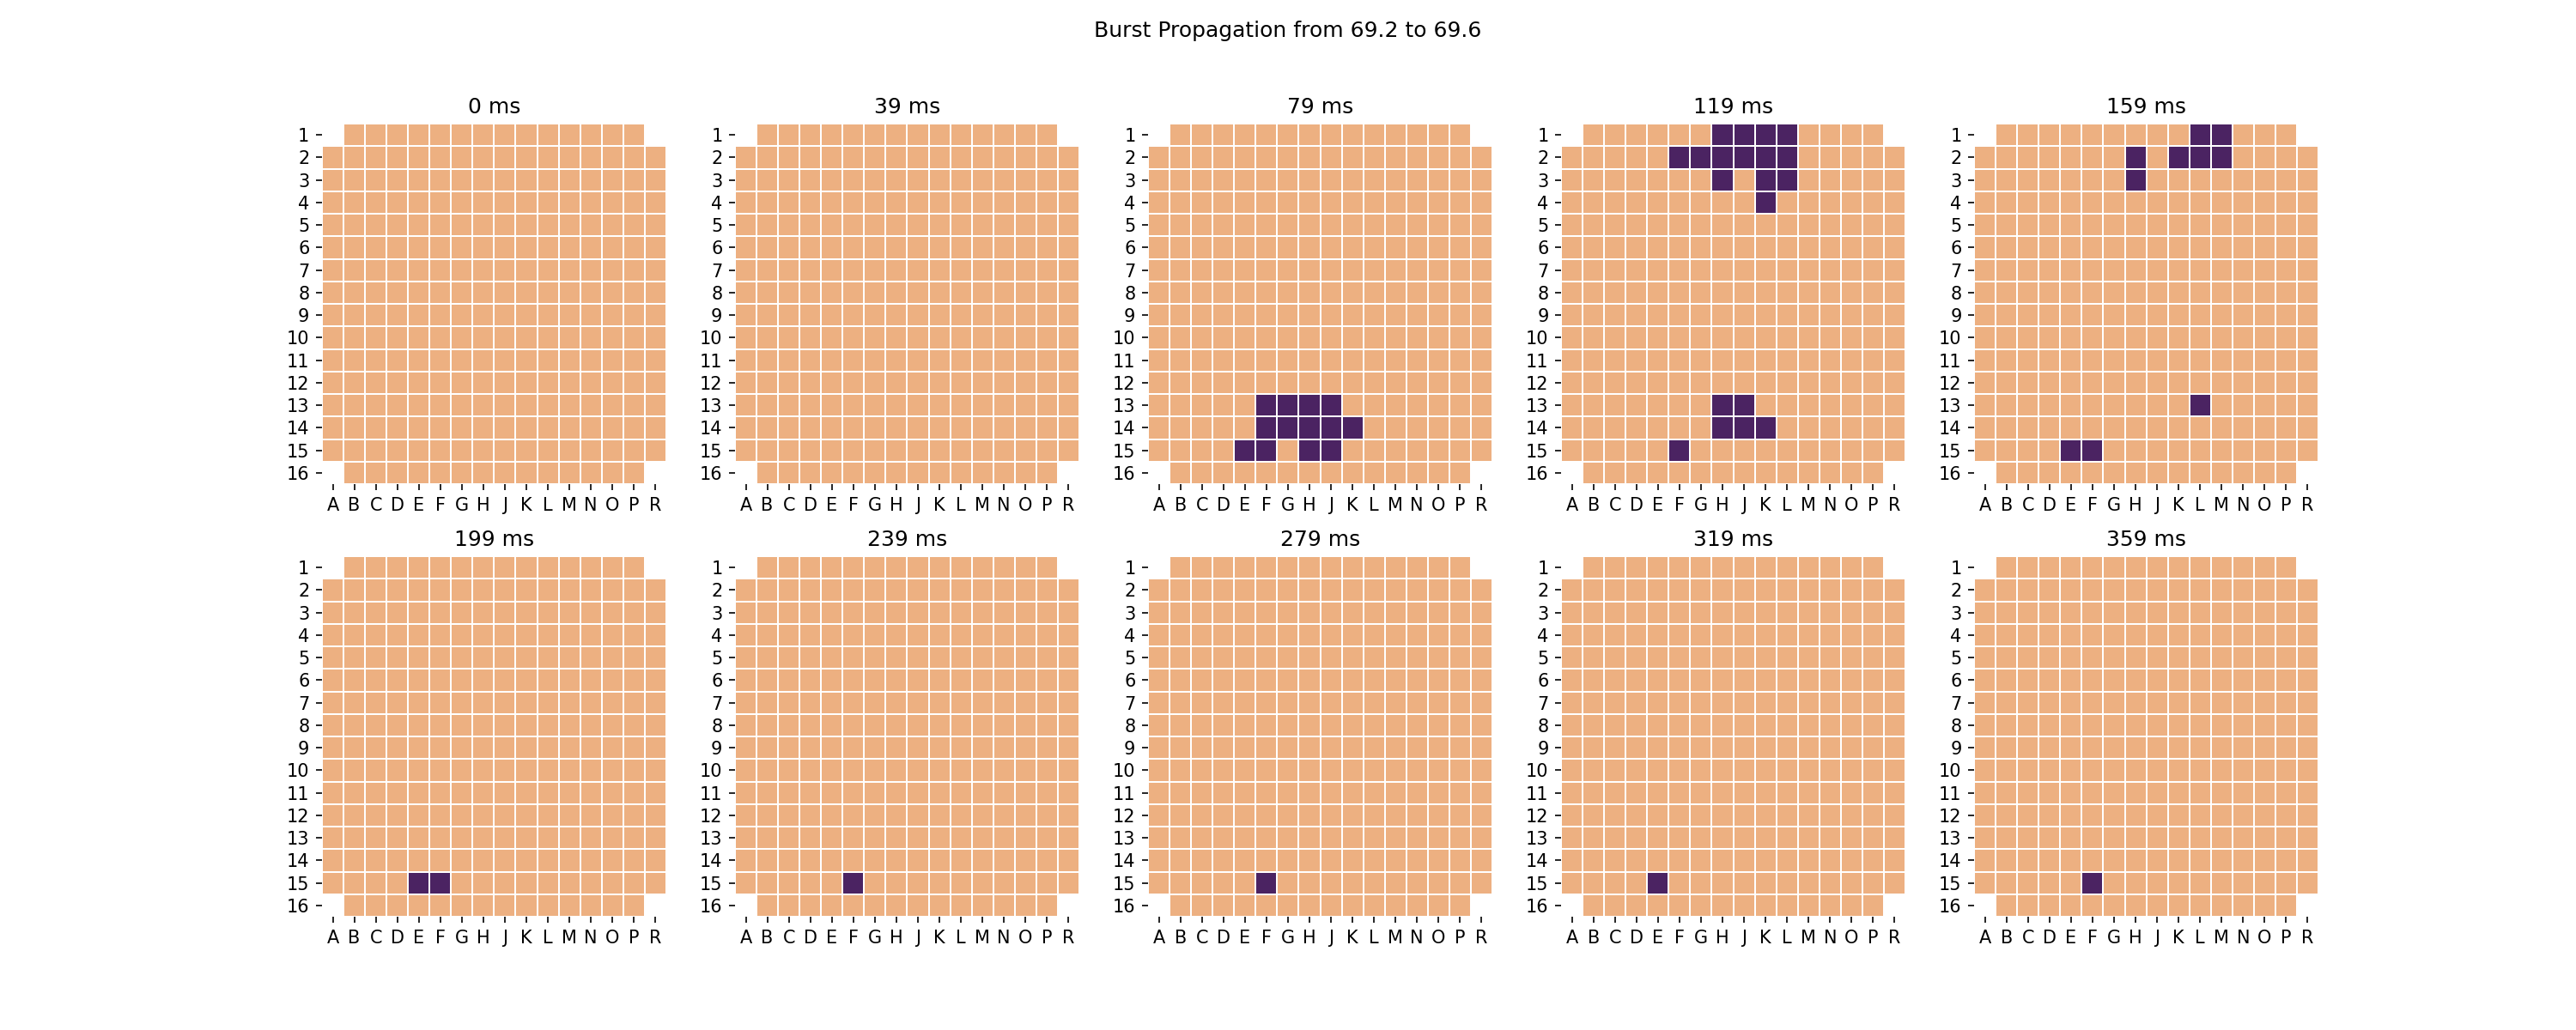

In [161]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

fig.savefig(filename +'_divided_burst_spatial_zoomed_09082021.png', dpi=300, bbox_inches = 'tight')